# Синхроннизация группы нейронов в сети Кропотова-Пахомова.

Исследуемая модель нейронной сети Кропотова-Пахомова отличается от оригинальной в одном пункте:

В качестве функции активации используется гиперболический тангенс: 
$N_{i}[t + 1] = \theta(N_{i}[t]) = \tanh(\beta N_{i}[t])$

Импортируем необходимые библиотеки:

In [1]:
import pywt
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.analysis import *
from kpnet.patterns import *

from wavelets import *

Зависимость функции $\tanh(\beta x)$ от параметра $\beta$: 

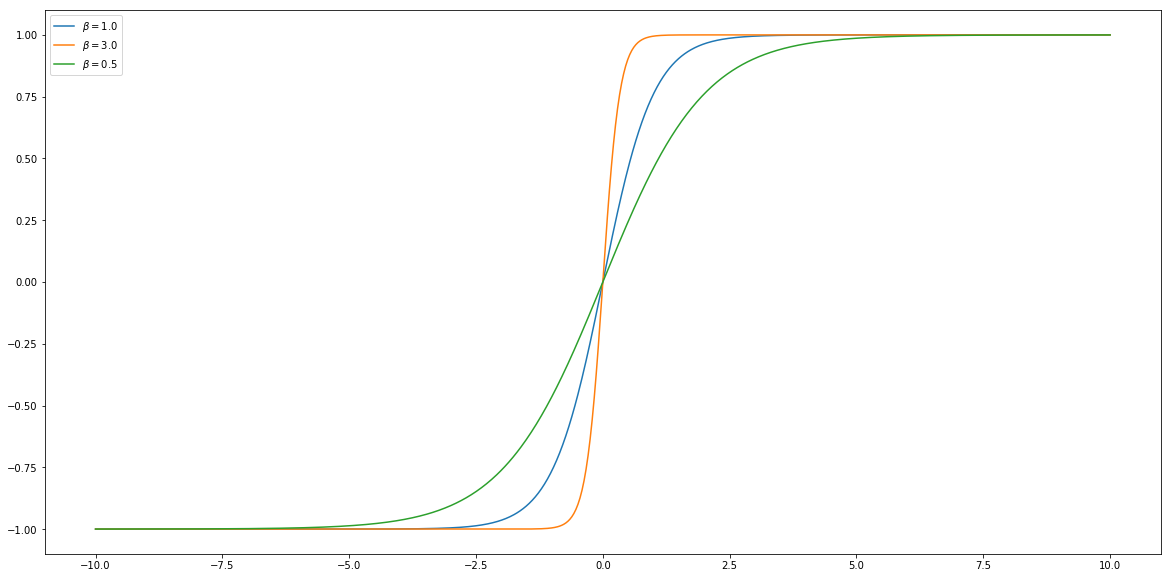

In [2]:
t = np.linspace(-10, 10, 1000)
plt.figure(figsize=(20, 10))
plt.plot(t, np.tanh(t), label=r'$\beta = 1.0$')
plt.plot(t, np.tanh(3.0 * t), label=r'$\beta = 3.0$')
plt.plot(t, np.tanh(0.5 * t), label=r'$\beta = 0.5$')
plt.legend(loc='upper left')
plt.show()

Будем исследовать сеть с 64 нейронами эволюционирующую $2 \times 10^5$ шагов.

In [3]:
neurons = 64
time_interval = 200000

Посчитаем следующие динамические характеристики сети:
1. Выходное значение с 5-ого нейрона.
2. Динамику связи 5-ого нейрона с другими: $\{W_{5j}^{0}[t],\ j \in {1, 128}\}$

В течении первых 2000 тысяч шагов на один случайно выбранный нейрон подавался импульс мощностью 0.5.

In [9]:
np.random.seed(6)
neuron = 5
net = KPNetworkTanhDelayed(neurons, 3, alpha=0.001, beta=0.2, gamma=3.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

for i in range(neurons):
    callbacks['W_' + str(i)] = WeightCallback(time_interval, neuron, i)

for i in range(7):
    callbacks['Trace_' + str(i)] = TraceCallback(time_interval, 300, i)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(neurons), ZeroSignal(neurons)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)

CPU times: user 11min 32s, sys: 188 ms, total: 11min 32s
Wall time: 11min 32s


Рассмотрим динамику выходного значения 5-ого нейрона:

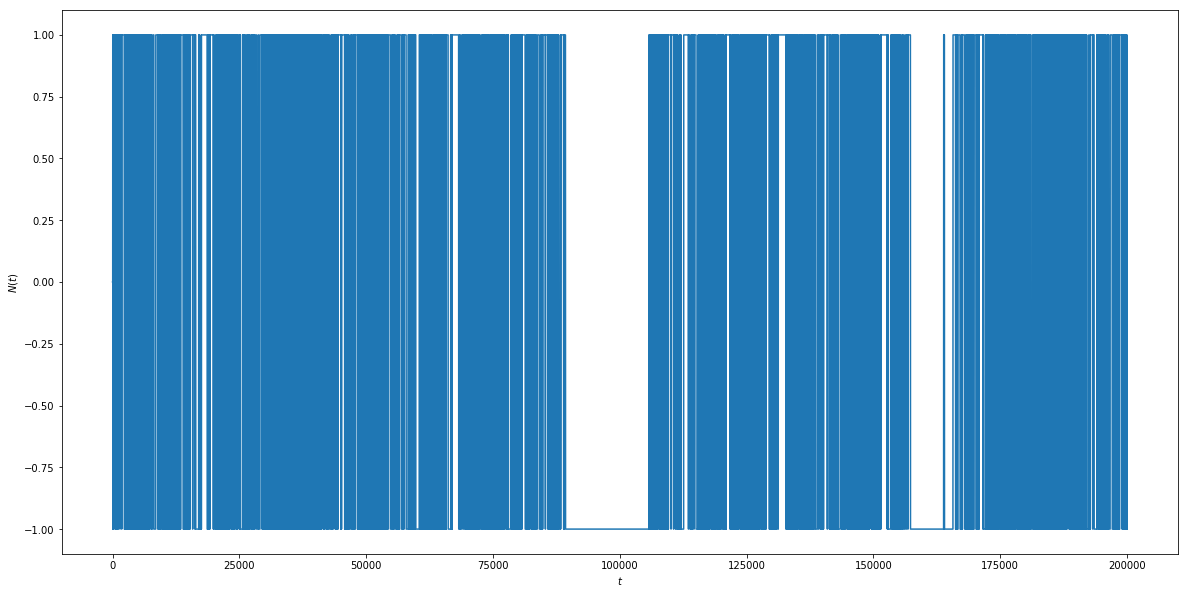

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(results['N_5'])
plt.ylabel(r'$N(t)$')
plt.xlabel(r'$t$')
plt.show()

Динамика следа нормализованной матрицы весов:

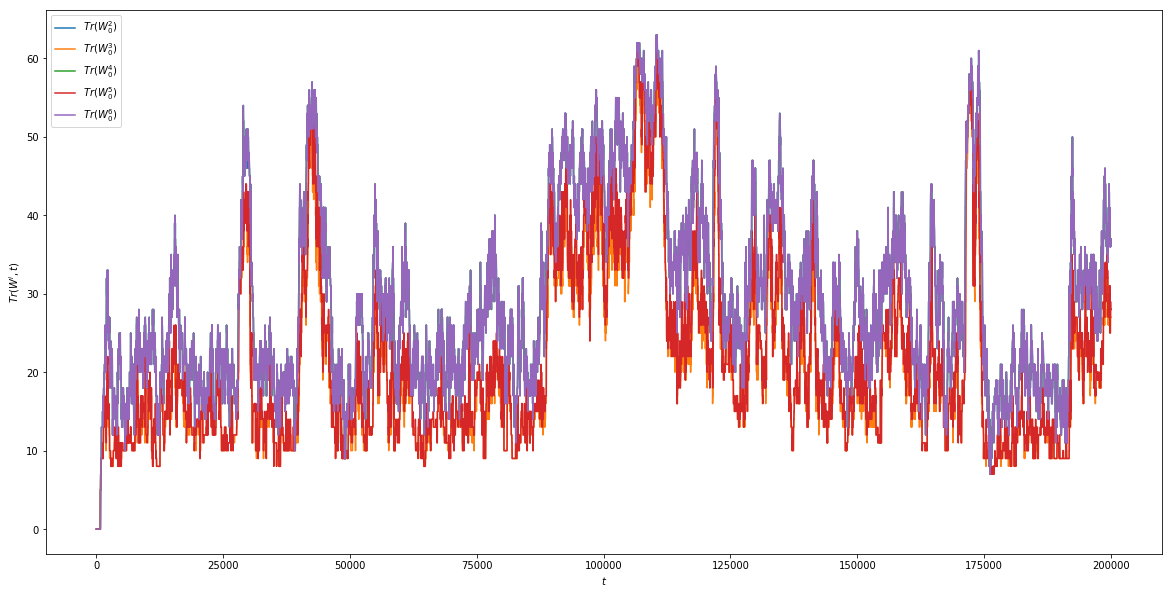

In [84]:
plt.figure(figsize=(20, 10))
for i in range(2, 7):
    plt.plot(results['Trace_' + str(i)], label=r'$Tr(W_{0}^' + str(i) + r')$')
plt.ylabel(r'$Tr(W^{i}, t)$')
plt.xlabel(r'$t$')
plt.legend(loc='upper left')
plt.show()

Обратим внимание на то, что в течении длительного времени выходное значение данного нейрона было равно -1. Для детального анализа рассмотрим веса некоторых ребёр, ведущих к данному нейрону.

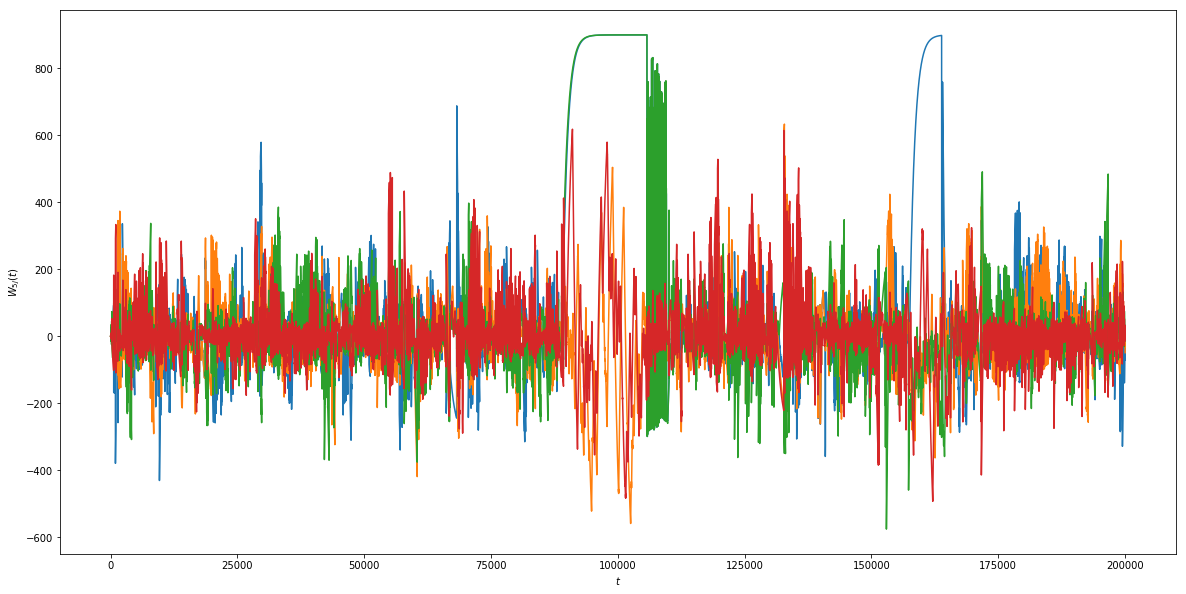

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_36'])
plt.plot(results['W_34'])
plt.plot(results['W_2'])
plt.plot(results['W_4'])
plt.xlabel(r'$t$')
plt.ylabel(r'$W_{5j}(t)$')
plt.show()

Как видно, некоторые веса имеют длительный асимптотический рост в интервале, когда 5-ый нейрон был неактивен. Рассмотрим спектрограмму такого динамики такого веса: 

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:7172: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


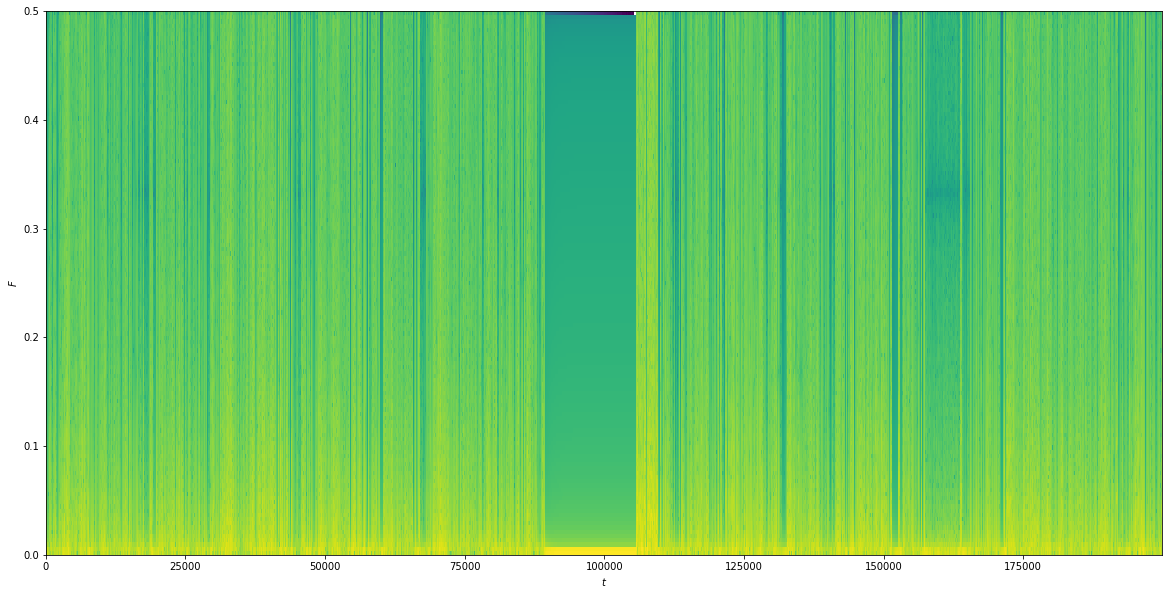

In [21]:
plt.figure(figsize=(20, 10))
plt.specgram(results['W_2'], 256, 1, 0)
plt.xlabel(r'$t$')
plt.ylabel(r'$F$')
plt.show()

Видно, что спектрограмма даёт мало информации о характерах изменения сигнала. Для более детального анализа воспользуемся вейвлет разложением данного сигнала.
$$W(s, \tau) = \frac{1}{\sqrt s}\int_{-\infty}^{+\infty}S(t)\bar\psi(\frac{t-\tau}{s}).$$
Где в качестве материнского вейвлета используется вторая производная плотности распределения Гаусса.

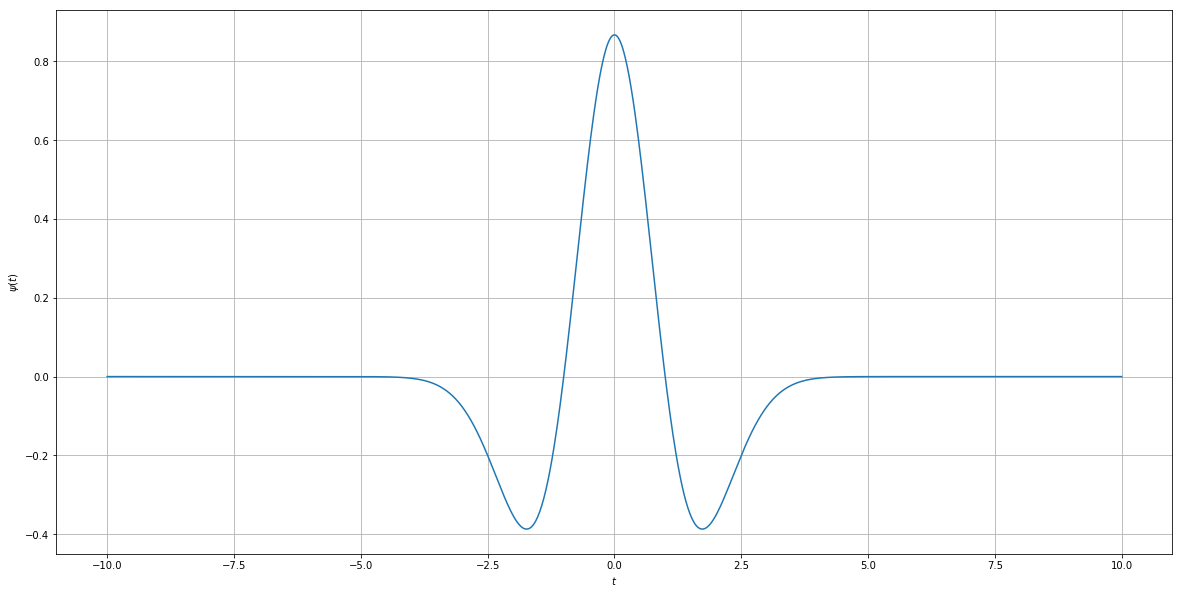

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(np.linspace(-10, 10, 1000), Ricker().time(np.linspace(-10, 10, 1000)))
plt.grid(True)
plt.xlabel(r'$t$')
plt.ylabel(r'$\psi(t)$')
plt.show()

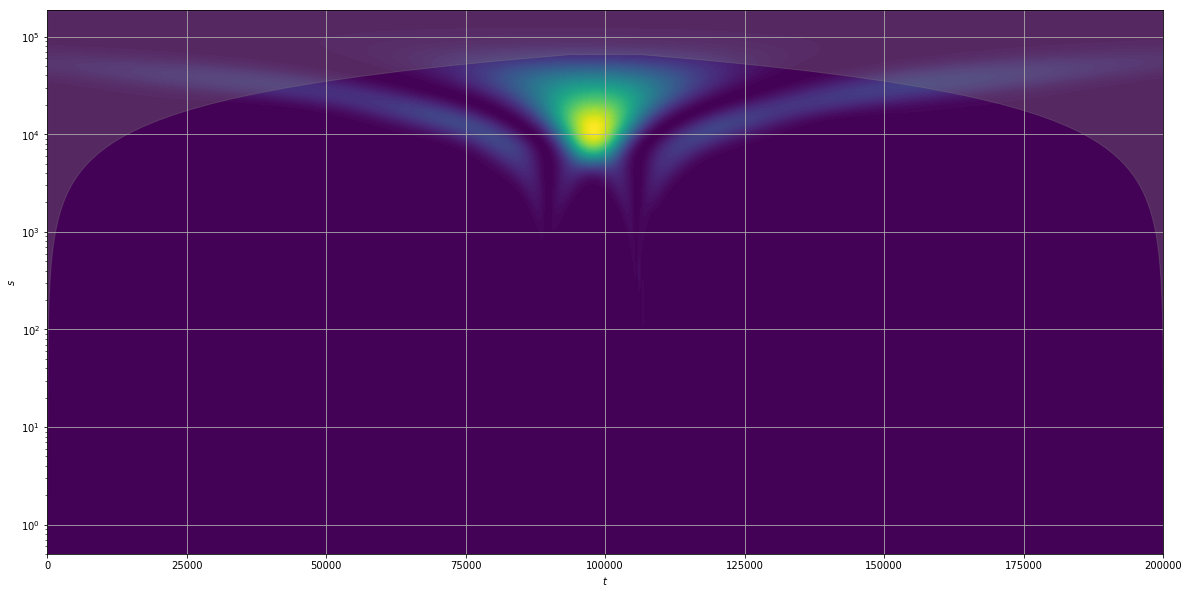

In [32]:
wa = WaveletAnalysis(results['W_2'], wavelet=Ricker())
fig = plt.figure(figsize=(20, 10)) 
ax = plt.subplot()
wa.plot_power(ax)
plt.xlabel(r'$t$')
plt.ylabel(r'$s$')
plt.show()

Как видно, непрервыное вейвле преобразование позволяет хорошо локализовать измнения в сигнале. Однако, в данном случае оно обладает большой избыточностью и требует значительный вычислительных ресурсов. К тому же само по себе вейвлет преобразование не даст количественной характерестики для сравнения нескольких сигналов.

Для решение данной проблемы можно сделать следующее:
1. Использовать дискретное вейвлет преобразование, то есть уровни $s$ будут принимать дискретные значения распределенные по степеням $2^{i},\ i \in \{1, \dotsc, l\}$;
2. На основании дискретных уровней ввести вейвлет энтропию, то есть меру распределения коэффициентов вейвлет преобразования по дискретным уровням:
$$H(p) = -\sum_{i=1}^{l}p_{i}\log(p_{i}),$$
где $p_{i} = \frac{E_{i}}{E},\ E_{i} = \frac{1}{N_{i}}\sum_{j=1}^{N_{i}}|C(i, j)|^2,\ E = \sum_{i=1}^{l}E_{i}$.
3. На основании вейвлет энтропии можно ввести велечину относительной вейвлет энтропии для двух распределений вейвлет преобразования $\{p\}_{i=1}^{l}, \{q\}_{i=1}^{l}$:
$$D_{KL}(p||q) = -\sum_{i=1}^{l}p_{i}\log(\frac{p_{i}}{q_{}i})$$

В качестве диксретного вейвлета был взять вейвлет db2 из семейства вейвлетов Добеши:

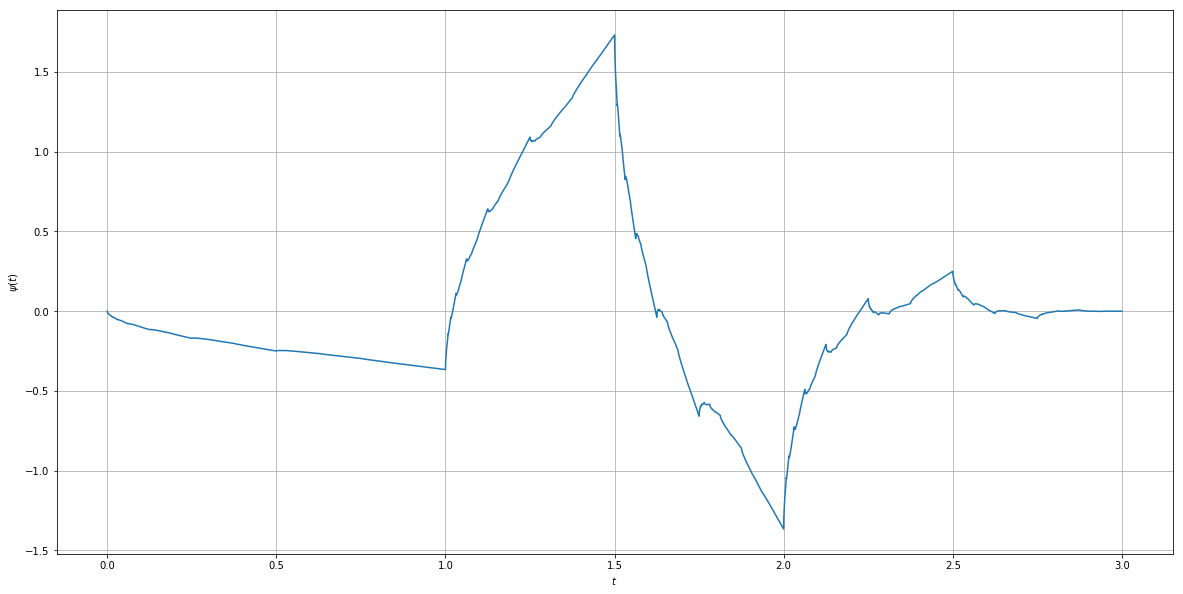

In [35]:
_, psi, t = pywt.Wavelet('db2').wavefun(level=14)
fig = plt.figure(figsize=(20, 10)) 
plt.plot(t, psi)
plt.grid(True)
plt.xlabel(r'$t$')
plt.ylabel(r'$\psi(t)$')
plt.show()

Вычислим вейвлет энтропии в окнах для двух "похожих" и "непохожих" сигналов весов:

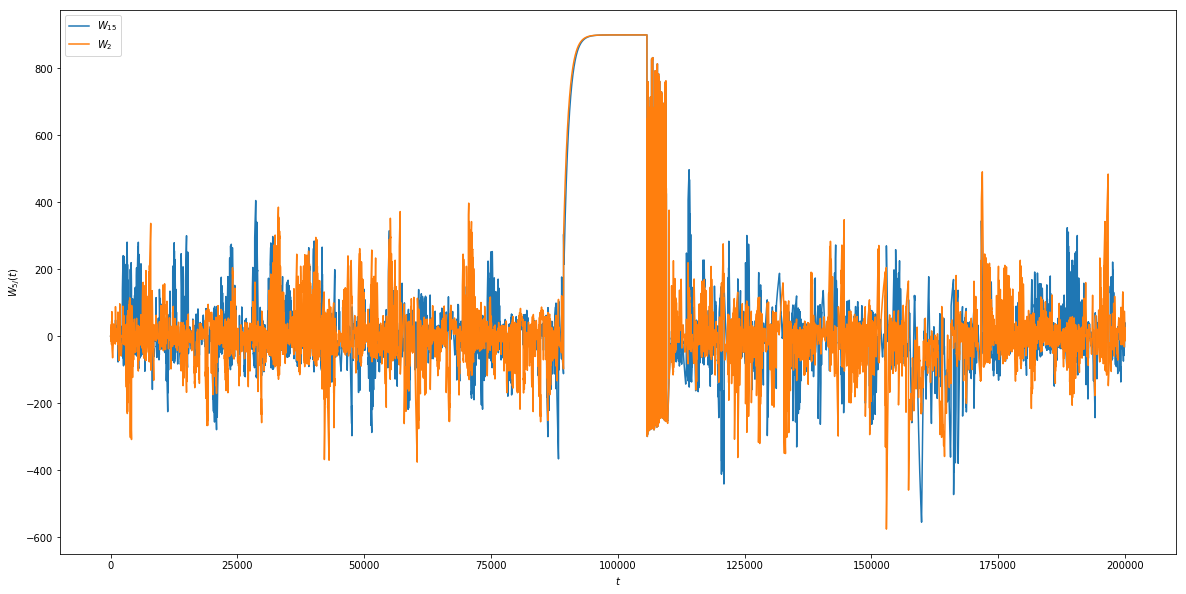

In [69]:
fig = plt.figure(figsize=(20, 10))
plt.plot(results['W_15'], label='$W_{15}$')
plt.plot(results['W_2'],  label='$W_{2}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$W_{5j}(t)$')
plt.legend(loc='upper left')
plt.show()

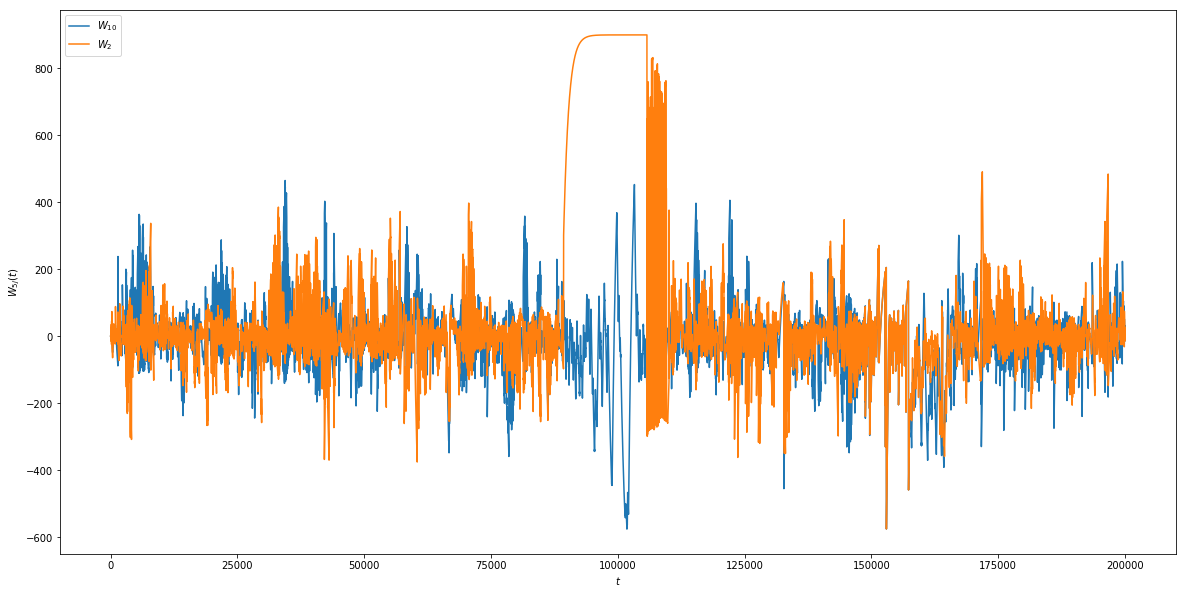

In [77]:
fig = plt.figure(figsize=(20, 10))
plt.plot(results['W_10'], label='$W_{10}$')
plt.plot(results['W_2'],  label='$W_{2}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$W_{5j}(t)$')
plt.legend(loc='upper left')
plt.show()

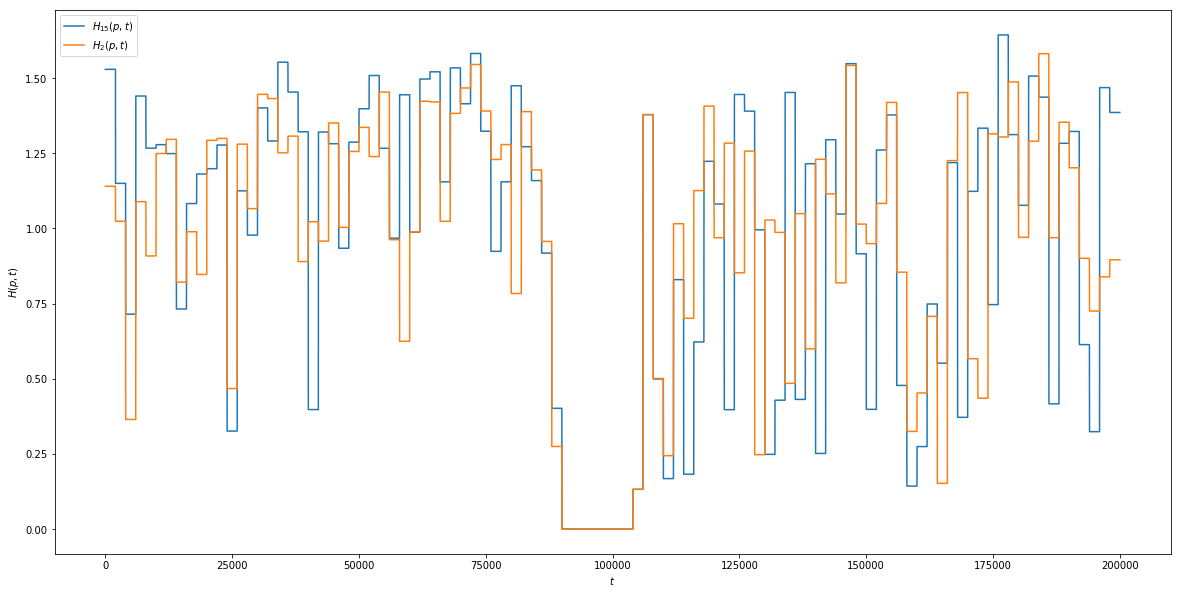

In [71]:
fig = plt.figure(figsize=(20, 10))
plt.plot(wentropy_d(results['W_15'], 2000, 'db2'), label='$H_{15}(p, t)$')
plt.plot(wentropy_d(results['W_2'], 2000, 'db2'), label='$H_{2}(p, t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$H(p, t)$')
plt.legend(loc='upper left')
plt.show()

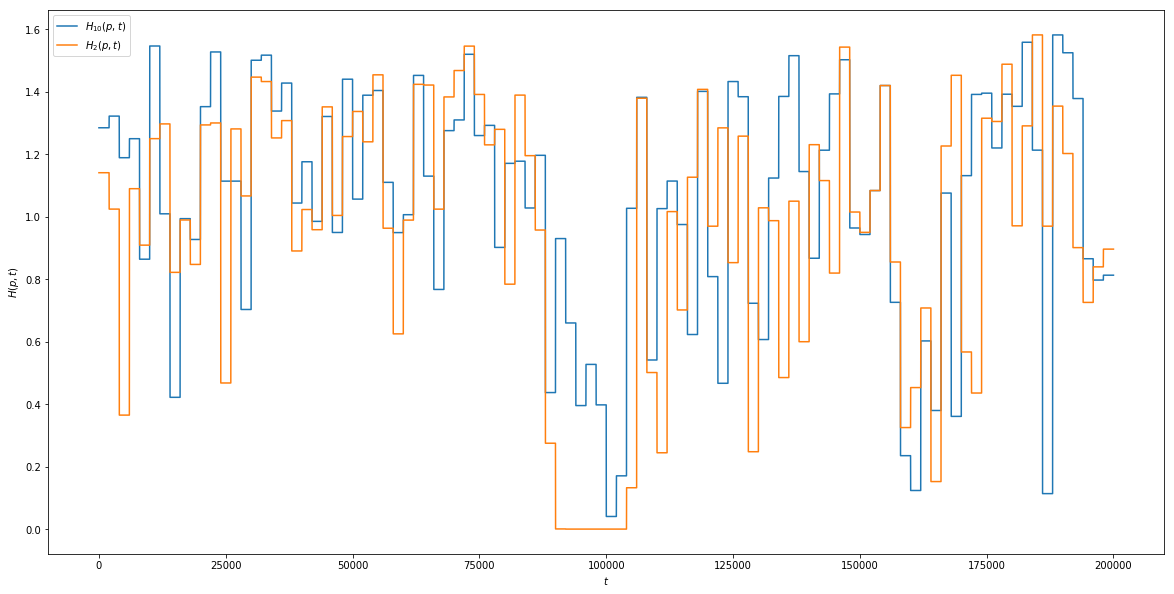

In [73]:
fig = plt.figure(figsize=(20, 10))
plt.plot(wentropy_d(results['W_10'], 2000, 'db2'), label='$H_{10}(p, t)$')
plt.plot(wentropy_d(results['W_2'], 2000, 'db2'), label='$H_{2}(p, t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$H(p, t)$')
plt.legend(loc='upper left')
plt.show()

Полная относительная вейвлет энтропия двух "похожих" сигналов:

In [67]:
print(wdivergence(results['W_15'], results['W_2'], 'db2'), 
      wdivergence(results['W_2'], results['W_15'], 'db2'))

0.00103781277432 0.00101052098398


Полная относительная вейвлет энтропия двух "непохожих" сигналов:

In [68]:
print(wdivergence(results['W_10'], results['W_2'], 'db2'), 
      wdivergence(results['W_2'], results['W_10'], 'db2'))

0.488110940613 0.253968363508


Посмотрим на динамику взаимной вейвлет энтропии двух сигналов:

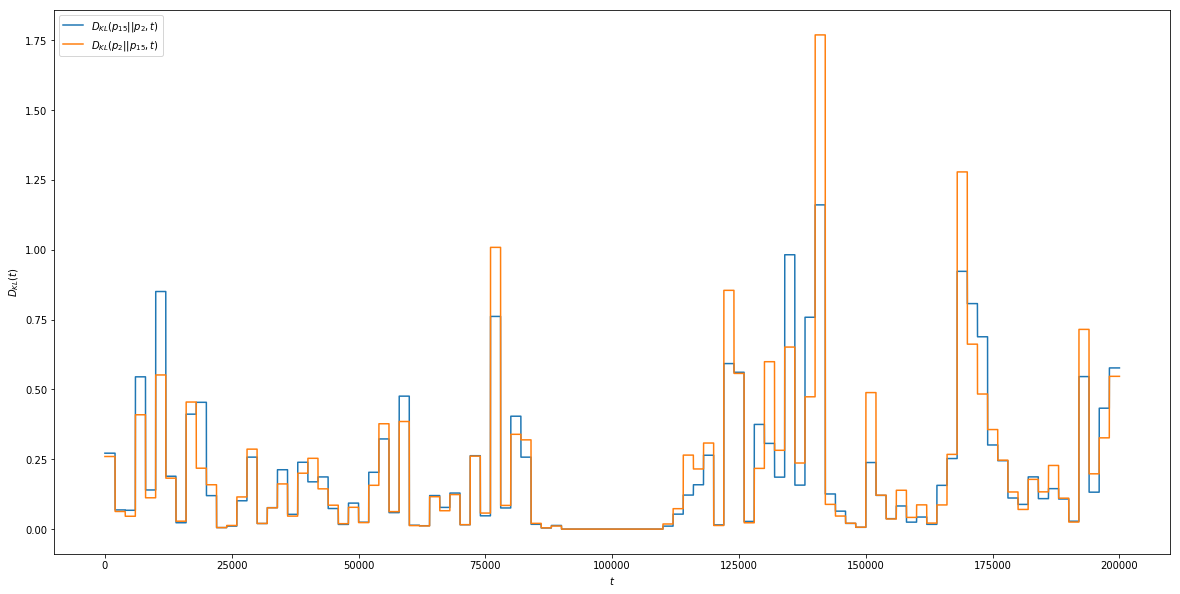

In [75]:
fig = plt.figure(figsize=(20, 10))
plt.plot(wdivergence_d(results['W_15'], results['W_2'], 2000, 'db2'), label='$D_{KL}(p_{15} || p_{2}, t)$')
plt.plot(wdivergence_d(results['W_2'], results['W_15'], 2000, 'db2'), label='$D_{KL}(p_{2} || p_{15}, t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$D_{KL}(t)$')
plt.legend(loc='upper left')
plt.show()

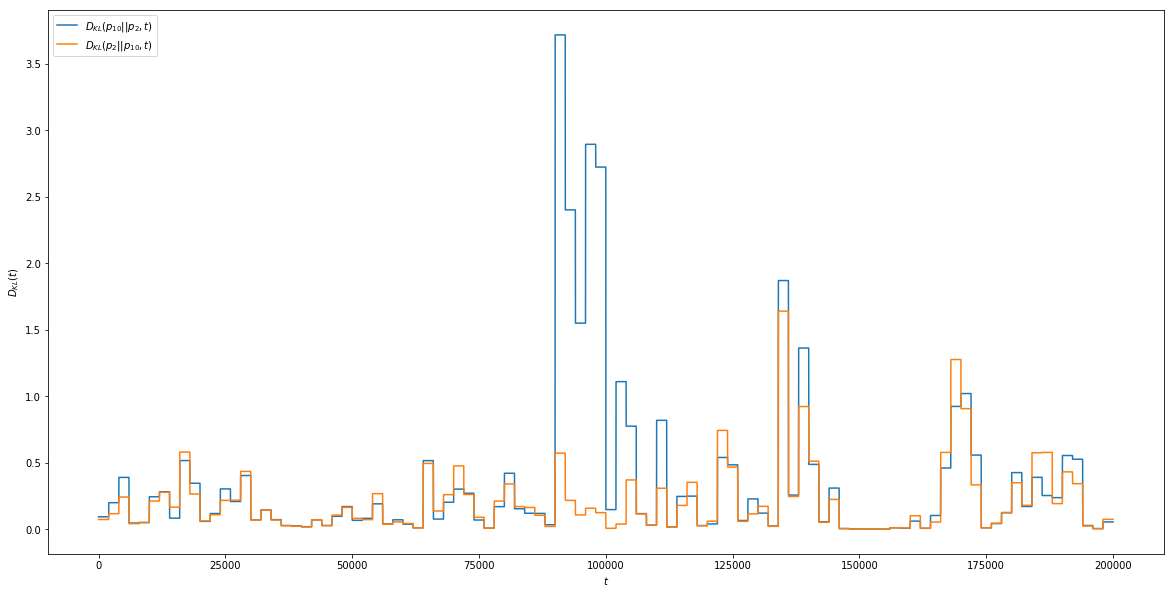

In [76]:
fig = plt.figure(figsize=(20, 10))
plt.plot(wdivergence_d(results['W_10'], results['W_2'], 2000, 'db2'), label='$D_{KL}(p_{10} || p_{2}, t)$')
plt.plot(wdivergence_d(results['W_2'], results['W_10'], 2000, 'db2'), label='$D_{KL}(p_{2} || p_{10}, t)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$D_{KL}(t)$')
plt.legend(loc='upper left')
plt.show()

Таким образом мерой для опередления похожести динамики двух (и более) нейронов можно определять по динамики их взаминой вейвлет энтропии